# Imports

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.utils import to_categorical # Utilizaré esta por conveniencia para One-Hot Encoding
from collections import Counter # Para el conteo de clases
import warnings
warnings.filterwarnings('ignore') # Ocultar advertencias de Pandas/sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

# Definición del mapeo de etiquetas
label_map = {0: 'N (Normal)', 1: 'S (Supraventricular)', 2: 'V (Ventricular)', 3: 'F (Fusionado)', 4: 'Q (Desconocido)'}

# Carga del Dataset

In [22]:
# Carga de los datasets
try:
    df_train = pd.read_csv('train/mitbih_train.csv', header=None)
    df_test = pd.read_csv('test/mitbih_test.csv', header=None)
except FileNotFoundError:
    print("Error: Asegúrate de que los archivos 'mitbih_train.csv' y 'mitbih_test.csv' estén en el directorio correcto.")
    # Si estás en Colab, deberás montar Google Drive o subir los archivos.
    
# Separación de features (X) y etiquetas (y)
X_train = df_train.iloc[:, :-1].copy()  # Señales (columnas 0 a 186)
y_train = df_train.iloc[:, -1].copy()   # Etiquetas (columna 187)

X_test = df_test.iloc[:, :-1].copy()
y_test = df_test.iloc[:, -1].copy()

print(f"✅ Datos de Entrenamiento cargados. Forma de X_train: {X_train.shape}")
print(f"✅ Datos de Prueba cargados. Forma de X_test: {X_test.shape}")

✅ Datos de Entrenamiento cargados. Forma de X_train: (87554, 187)
✅ Datos de Prueba cargados. Forma de X_test: (21892, 187)


# 1. Análisis Exploratorio de Datos (EDA)

## Visualización Forma de las Señales

Visualizando una muestra de latido para cada una de las 5 clases:


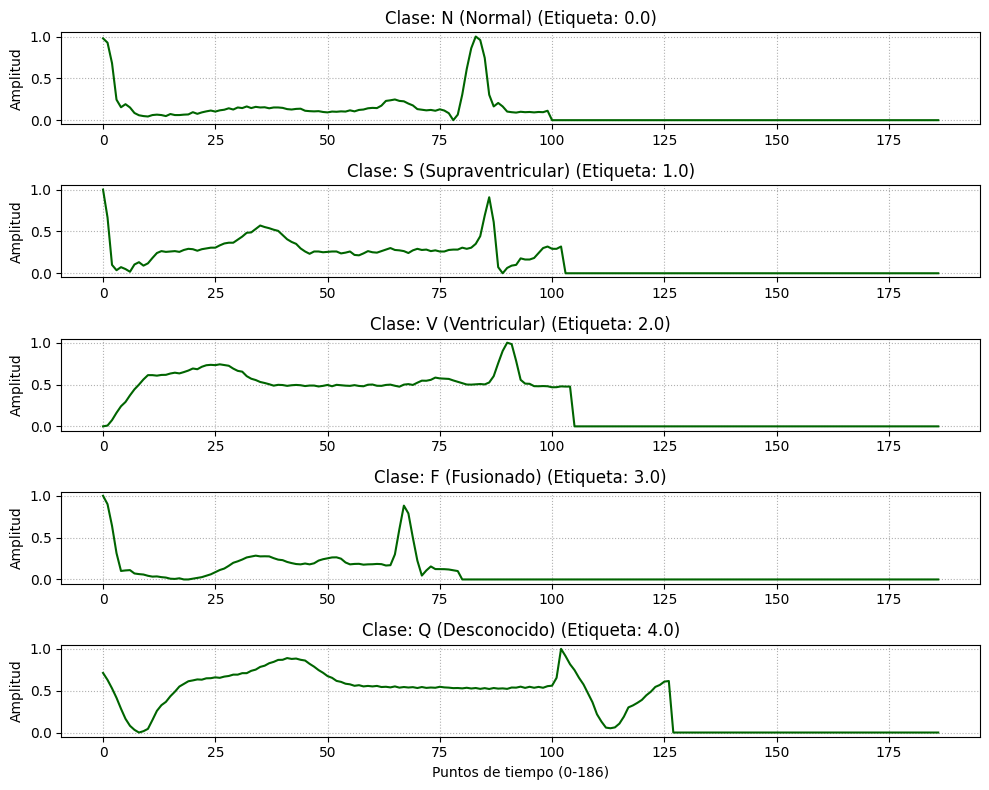

In [32]:
plt.figure(figsize=(10, 8))
classes = sorted(y_train.unique())

print("Visualizando una muestra de latido para cada una de las 5 clases:")

for i, class_label in enumerate(classes):
    plt.subplot(len(classes), 1, i + 1)
    
    # Encontrar el índice de la primera ocurrencia
    sample_index = y_train[y_train == class_label].index[0]
    
    # Obtener la señal
    signal = X_train.loc[sample_index]
    
    plt.plot(signal, color='darkgreen')
    plt.title(f'Clase: {label_map[class_label]} (Etiqueta: {class_label})', fontsize=12)
    plt.ylabel('Amplitud')
    plt.grid(True, linestyle=':')

plt.xlabel('Puntos de tiempo (0-186)')
plt.tight_layout()
plt.show()

## Desbalanceo de Clases

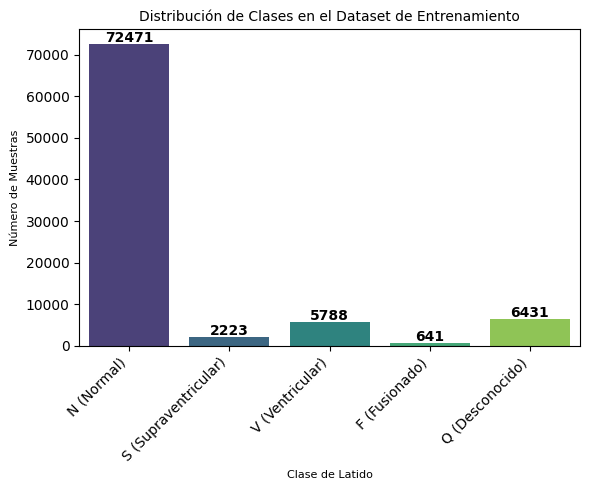


La Clase 0 (Normal) representa el 82.77% del dataset.


In [30]:
class_counts = y_train.value_counts().sort_index()
total_samples = class_counts.sum()
normal_percentage = (class_counts[0] / total_samples) * 100

plt.figure(figsize=(6, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

plt.xticks(ticks=class_counts.index, labels=[label_map[i] for i in class_counts.index], rotation=45, ha='right')

plt.title('Distribución de Clases en el Dataset de Entrenamiento', fontsize=10)
plt.xlabel('Clase de Latido', fontsize=8)
plt.ylabel('Número de Muestras', fontsize=8)

for index, value in enumerate(class_counts):
    plt.text(index, value + 500, f'{value}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nLa Clase 0 (Normal) representa el {normal_percentage:.2f}% del dataset.")

## Análisis Estadístico

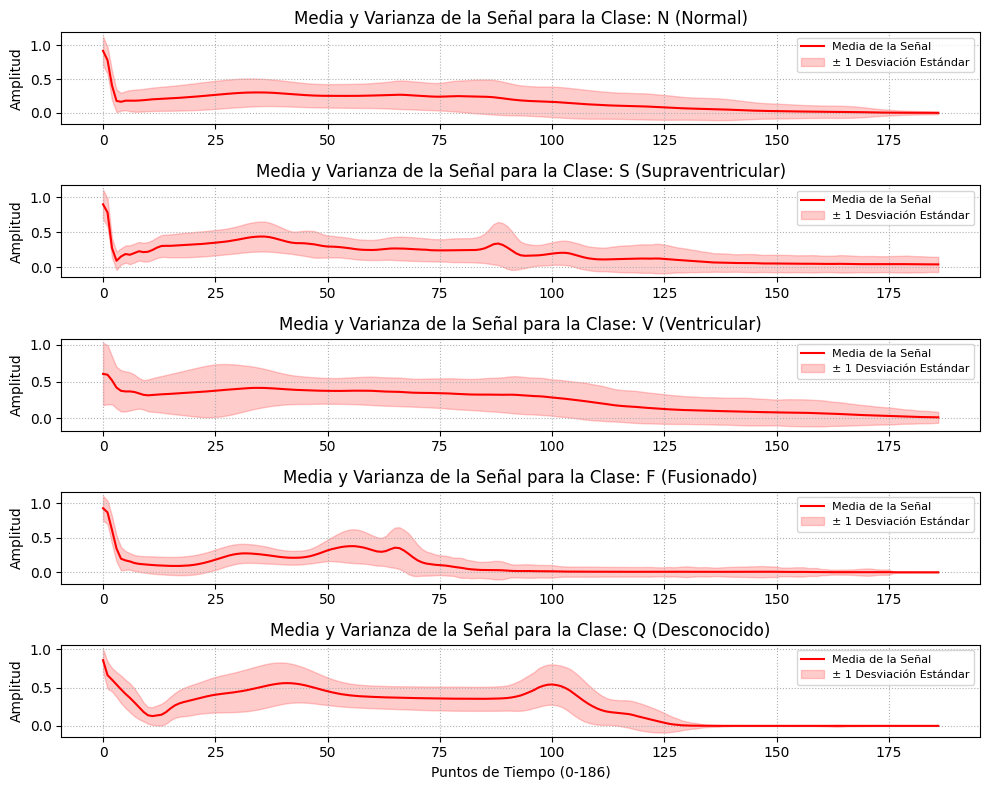

In [34]:
plt.figure(figsize=(10, 8))

# Agrupar los datos de entrenamiento por clase
grouped_data = df_train.groupby(187) 

# Iterar sobre cada clase para calcular y graficar estadísticas
for i, class_label in enumerate(sorted(y_train.unique())):
    plt.subplot(5, 1, i + 1)
    
    # Seleccionar las señales para la clase actual
    signals_class = grouped_data.get_group(class_label).iloc[:, :-1]
    
    # Calcular la media y la desviación estándar a lo largo del eje de tiempo (columnas)
    mean_signal = signals_class.mean(axis=0)
    std_signal = signals_class.std(axis=0)
    
    time_points = np.arange(signals_class.shape[1])
    
    # Graficar la media
    plt.plot(time_points, mean_signal, label='Media de la Señal', color='red')
    
    # Rellenar el área de +/- 1 desviación estándar para mostrar la varianza
    plt.fill_between(time_points, mean_signal - std_signal, mean_signal + std_signal, 
                     color='red', alpha=0.2, label='± 1 Desviación Estándar')
    
    plt.title(f'Media y Varianza de la Señal para la Clase: {label_map[class_label]}', fontsize=12)
    plt.ylabel('Amplitud')
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right', fontsize=8)

plt.xlabel('Puntos de Tiempo (0-186)')
plt.tight_layout()
plt.show()


## Distribución de Amplitudes Promedio

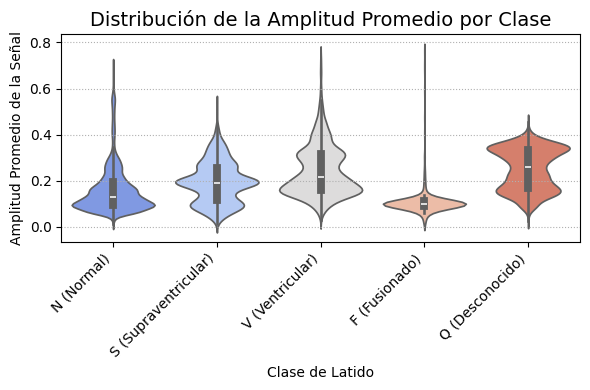

In [36]:
X_train['mean_amplitude'] = X_train.mean(axis=1)

plt.figure(figsize=(6, 4))

# Usar un violín plot para comparar distribuciones
sns.violinplot(x=y_train, y=X_train['mean_amplitude'], palette="coolwarm")

# Ajustar etiquetas
plt.xticks(ticks=y_train.unique(), labels=[label_map[i] for i in sorted(y_train.unique())], rotation=45, ha='right')
plt.title('Distribución de la Amplitud Promedio por Clase', fontsize=14)
plt.xlabel('Clase de Latido')
plt.ylabel('Amplitud Promedio de la Señal')
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()

# Eliminar la columna temporal
X_train = X_train.drop(columns=['mean_amplitude'])


## Correlación entre puntos

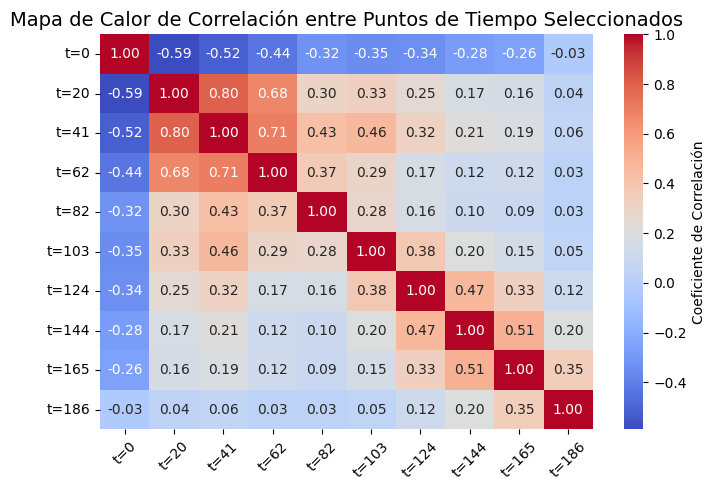

In [40]:
# Seleccionar 10 puntos de tiempo espaciados uniformemente (características)
num_features = X_train.shape[1]
time_indices = np.linspace(0, num_features - 1, 10, dtype=int) 
selected_features = X_train.iloc[:, time_indices]

# Calcular la matriz de correlación
correlation_matrix = selected_features.corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            cbar_kws={'label': 'Coeficiente de Correlación'})

# Personalizar etiquetas
tick_labels = [f't={i}' for i in time_indices]
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels, rotation=45)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels, rotation=0)

plt.title('Mapa de Calor de Correlación entre Puntos de Tiempo Seleccionados', fontsize=14)
plt.tight_layout()
plt.show()


## Histograma de Amplitudes

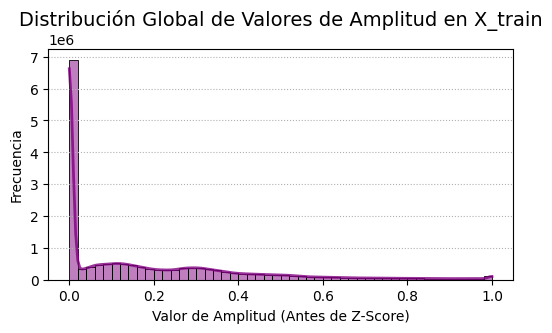

In [39]:
all_amplitudes = X_train.values.flatten()

plt.figure(figsize=(6, 3))
# Usar histplot para generar el histograma
sns.histplot(all_amplitudes, bins=50, kde=True, color='purple', 
             line_kws={'linewidth': 2, 'alpha': 0.8})

plt.title('Distribución Global de Valores de Amplitud en X_train', fontsize=14)
plt.xlabel('Valor de Amplitud (Antes de Z-Score)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle=':')
plt.show()


# 2. Insights del EDA


## Desafío Crítico: Desbalanceo de Clases

| Detalle | Decisión de Implementación (PyTorch) | Justificación (Análisis 3) |
| :--- | :--- | :--- |
| **Relación de Clases** | La clase **N (Normal)** (82.77%) domina, con una relación de **113:1** respecto a la clase **F (Fusionado)** (0.73%). | Un modelo sin mitigación predeciría ciegamente 'N', dando un *Accuracy* alto pero fallando en la detección de arritmias (clases minoritarias). |
| **Estrategia** | **`nn.CrossEntropyLoss` con `class_weights`**. Los pesos son inversamente proporcionales a la frecuencia de cada clase. | Esto obliga al modelo a penalizar fuertemente los errores en las clases raras (S, F), forzando el aprendizaje de sus características. |
| **Métricas** | Evaluación basada en **F1-Macro**, **Precision** y **Recall** por clase. | El *Accuracy* es engañoso. El F1-Macro proporciona una medida robusta de la capacidad predictiva en *todas* las clases. |

---

## Desafío de la Amplitud y Convergencia

| Detalle | Decisión de Implementación (PyTorch) | Justificación (Análisis 7) |
| :--- | :--- | :--- |
| **Distribución Global** | El histograma de amplitudes muestra un pico extremo en $0.0$, y aunque el rango es $[0, 1]$, los datos no están centrados. | El entrenamiento de redes profundas converge más rápido y de forma más estable cuando los datos de entrada están **centrados en cero** ($media=0$). |
| **Estrategia** | **Normalización Z-Score Global**. Fórmula: $\text{Señal}_{\text{norm}} = (\text{Señal} - \mu_{\text{global}}) / \sigma_{\text{global}}$. | Se calcula la media ($\mu$) y desviación estándar ($\sigma$) de **todo** el conjunto de entrenamiento para estandarizar la escala. Esto evita la saturación de las neuronas RNN. |

---

## Justificación de la Arquitectura Recurrente (LSTM/GRU)

| Detalle | Decisión de Implementación (PyTorch) | Justificación (Análisis 4 y 6) |
| :--- | :--- | :--- |
| **Naturaleza del Dato** | La forma de onda es una **Serie de Tiempo**; las arritmias son patrones que se desarrollan en el tiempo (187 puntos). | Un **MLP** (Red *Feedforward*) ignora la secuencia. La **LSTM/GRU** es esencial porque su memoria interna puede capturar dependencias a corto plazo (correlación local) y a largo plazo (la forma completa del latido). |
| **Profundidad** | Se utilizará una arquitectura con **dos o más capas recurrentes** apiladas (`num_layers > 1`). | Las capas múltiples permiten al modelo aprender **jerarquías**: la primera capa capta rasgos básicos de la señal y las siguientes integran esos rasgos en patrones temporales más complejos y específicos de cada arritmia. |

# 3. Preprocesamiento y DataLoaders

In [47]:
X_train_np = X_train.values
GLOBAL_MEAN = X_train_np.mean()
GLOBAL_STD = X_train_np.std()

# 2.2. Cálculo de Pesos de Clase (class_weights) (Análisis 3)
# La clase 0 (Normal) representa el 82.77% y la clase 3 (Fusionado) el 0.73%.
# Usamos el inverso de la frecuencia.
train_counts = Counter(y_train.values)
total_samples = sum(train_counts.values())
num_classes = len(train_counts)

# Los pesos se calculan como: 1 / frecuencia_relativa
# Para balancear la balanza, usamos el peso más alto (el de la clase más rara) como base.
max_count = max(train_counts.values())
class_weights = torch.zeros(num_classes, dtype=torch.float32)

for i in range(num_classes):
    # Peso = max_count / count_de_la_clase
    class_weights[i] = max_count / train_counts.get(i, 1) # Usar 1 por si una clase falta (no debería pasar)

# Normalizar los pesos para que el tensor de pérdida se inicialice bien
class_weights = class_weights / class_weights.sum()

print("--- Constantes de Preprocesamiento Calculadas ---")
print(f"Media Global (mu): {GLOBAL_MEAN:.6f}")
print(f"Desviación Estándar Global (sigma): {GLOBAL_STD:.6f}")
print(f"Pesos de Clase Inversos (para nn.CrossEntropyLoss):")
for i, weight in enumerate(class_weights):
    print(f"  Clase {i} (Peso: {weight:.4f})")



--- Constantes de Preprocesamiento Calculadas ---
Media Global (mu): 0.174283
Desviación Estándar Global (sigma): 0.226327
Pesos de Clase Inversos (para nn.CrossEntropyLoss):
  Clase 0 (Peso: 0.0059)
  Clase 1 (Peso: 0.1913)
  Clase 2 (Peso: 0.0735)
  Clase 3 (Peso: 0.6633)
  Clase 4 (Peso: 0.0661)


In [50]:
# --- 3. DEFINICIÓN DEL DATASET DE PYTORCH ---

class ECGDataset(Dataset):
    """
    Clase de Dataset personalizada para datos de ECG en PyTorch.
    Aplica Normalización Z-Score y reformatea la señal.
    """
    def __init__(self, X, y, mean, std):
        # Conversión a NumPy (si viene de Pandas) y a Float32
        self.X = X.values.astype(np.float32)
        self.y = y.values

        # Constantes de Normalización Z-Score
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # 1. Obtener la señal y la etiqueta
        signal = self.X[idx]
        label = self.y[idx]

        # 2. Aplicar Normalización Z-Score (Decisión del Análisis 7)
        if self.std != 0:
            signal = (signal - self.mean) / self.std
        
        # 3. Reformatear la señal a (L, H) = (187, 1) para la RNN
        # Las RNNs en PyTorch esperan (batch_size, sequence_length, input_size)
        # O (sequence_length, batch_size, input_size)
        # Aquí la reformateamos a (187, 1) para que el DataLoader la convierta a (B, 187, 1)
        # El input_size es 1 porque es una serie de tiempo univariada.
        signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(-1)
        
        # 4. Convertir la etiqueta a tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return signal_tensor, label_tensor


In [51]:
# NOTA: Los datos de Test (X_test, y_test) se usarán como el conjunto final.
# La validación (X_val, y_val) se extrae del conjunto de entrenamiento original (X_train, y_train).

# 1. Definir el tamaño de la validación (usaremos un 20% del total de entrenamiento original)
# El conjunto de entrenamiento original es de 87554 muestras. El 20% es ~17511.
VAL_SIZE = 0.2
RANDOM_SEED = 42

# 2. División de X_train/y_train en X_train_new/y_train_new y X_val/y_val
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train,
    test_size=VAL_SIZE,
    random_state=RANDOM_SEED,
    # El stratify es CRÍTICO: asegura que el desbalanceo se mantenga en los tres conjuntos.
    stratify=y_train 
)

print("--- División de Datos Completada ---")
print(f"X_train (nuevo) size: {X_train_new.shape[0]} muestras")
print(f"X_val size: {X_val.shape[0]} muestras")
print(f"X_test size: {X_test.shape[0]} muestras (Sin tocar)")



--- División de Datos Completada ---
X_train (nuevo) size: 70043 muestras
X_val size: 17511 muestras
X_test size: 21892 muestras (Sin tocar)


In [55]:
BATCH_SIZE = 1024

# 1. Creación de instancias de Dataset
# Importante: Utilizamos las constantes GLOBAL_MEAN y GLOBAL_STD calculadas previamente
train_dataset = ECGDataset(X_train_new, y_train_new, GLOBAL_MEAN, GLOBAL_STD)
val_dataset = ECGDataset(X_val, y_val, GLOBAL_MEAN, GLOBAL_STD)
test_dataset = ECGDataset(X_test, y_test, GLOBAL_MEAN, GLOBAL_STD) # El test_dataset ya usa X_test/y_test

# 2. Creación de instancias de DataLoader
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,          # Importante para entrenamiento
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No se necesita mezclar en validación
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,         # No se necesita mezclar en test
    num_workers=0
)

# --- VERIFICACIÓN FINAL DE ESTRUCTURA ---

print("\n--- Verificación de Estructura de DataLoaders ---")
print(f"Batches de Entrenamiento (train_loader): {len(train_loader)}")
print(f"Batches de Validación (val_loader): {len(val_loader)}")
print(f"Batches de Prueba (test_loader): {len(test_loader)}")

# Inspección de un batch de Validación
for signals, labels in val_loader:
    print(f"\nTensor de Validación (Batch): {signals.shape}")
    print(f"Formato esperado para RNN/LSTM: (BATCH_SIZE, 187, 1)")
    break


--- Verificación de Estructura de DataLoaders ---
Batches de Entrenamiento (train_loader): 69
Batches de Validación (val_loader): 18
Batches de Prueba (test_loader): 22

Tensor de Validación (Batch): torch.Size([1024, 187, 1])
Formato esperado para RNN/LSTM: (BATCH_SIZE, 187, 1)


In [56]:
# --- CÓDIGO DE VERIFICACIÓN DE NORMALIZACIÓN Z-SCORE ---

# Tomamos un solo batch del DataLoader de entrenamiento
for signals, labels in train_loader:
    # signals es el tensor con la forma (Batch Size, Sequence Length, Input Size) -> (64, 187, 1)
    
    # Aplanamos el tensor para inspeccionar todos los valores en el batch
    all_values_in_batch = signals.flatten()
    
    # Calculamos la media y la desviación estándar de este batch
    batch_mean = all_values_in_batch.mean().item()
    batch_std = all_values_in_batch.std().item()

    print("\n--- Verificación de Normalización en el Primer Batch ---")
    print(f"Media del Batch (Esperado ~ 0.0): {batch_mean:.6f}")
    print(f"Desviación Estándar del Batch (Esperado ~ 1.0): {batch_std:.6f}")
    
    # Comprobación simple para confirmar la normalización
    if abs(batch_mean) < 0.01 and abs(batch_std - 1.0) < 0.05:
        print("✅ Resultado: La Normalización Z-Score parece ser correcta.")
    else:
        print("❌ Advertencia: La media o la desviación están fuera del rango esperado. Revisar GLOBAL_MEAN/GLOBAL_STD.")
        
    break # Solo necesitamos inspeccionar el primer batch

# Puedes imprimir también el rango (Min y Max) para ver que los valores se han extendido.
print(f"Valor Mínimo en el Batch: {all_values_in_batch.min().item():.4f}")
print(f"Valor Máximo en el Batch: {all_values_in_batch.max().item():.4f}")


--- Verificación de Normalización en el Primer Batch ---
Media del Batch (Esperado ~ 0.0): -0.004031
Desviación Estándar del Batch (Esperado ~ 1.0): 1.001351
✅ Resultado: La Normalización Z-Score parece ser correcta.
Valor Mínimo en el Batch: -0.7700
Valor Máximo en el Batch: 3.6483


# 4. Modelo Base LSTM

In [57]:
import torch
import torch.nn as nn

SEQ_LENGTH = 187
INPUT_SIZE = 1
NUM_CLASSES = 5 

# --- Decisión de Diseño de Arquitectura (Análisis 4 y 6) ---
HIDDEN_SIZE = 64  # Tamaño del estado oculto (memoria)
NUM_LAYERS = 2    # Profundidad de la LSTM (Justificado por correlación)
DROPOUT_RATE = 0.2 # Regularización para evitar sobreajuste

In [59]:
class ECGClassifier(nn.Module):
    """
    Clasificador de Latidos de ECG basado en una Red LSTM Apilada.

    Arquitectura:
    1. 2x Capas LSTM para capturar la dependencia temporal.
    2. Capa Dropout para regularización.
    3. Capa Lineal (Dense) para mapear el estado final a las 5 clases.
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.2):
        super(ECGClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 1. Capa LSTM Apilada
        # batch_first=True: Indica que la entrada será (Batch, Sequence, Feature)
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0 # Aplicar dropout entre capas si hay más de 1
        )
        
        # 2. Capa Lineal (Clasificador)
        # Toma la salida del último paso de tiempo de la última capa LSTM (hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size) -> e.g., (64, 187, 1)

        # Inicialización del estado oculto y de la célula (h0 y c0)
        # h0/c0 shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pasar los datos por la LSTM
        # out shape: (batch_size, seq_length, hidden_size)
        # h_n, c_n shape: (num_layers, batch_size, hidden_size)
        out, (h_n, c_n) = self.rnn(x, (h0, c0))
        
        # Seleccionar la salida del ÚLTIMO paso de tiempo (t=186) de la ÚLTIMA capa
        # Usamos out[:, -1, :] que es equivalente a h_n[-1] si batch_first=True
        # out_last_step shape: (batch_size, hidden_size)
        out_last_step = out[:, -1, :]
        
        # Pasar a través de la capa Lineal para clasificación
        # out shape: (batch_size, num_classes)
        out = self.fc(out_last_step)
        
        return out

#MAKE SUMMARY
model = ECGClassifier(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE
)
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ECGClassifier                            [1024, 5]                 --
├─LSTM: 1-1                              [1024, 187, 64]           50,432
├─Linear: 1-2                            [1024, 5]                 325
Total params: 50,757
Trainable params: 50,757
Non-trainable params: 0
Total mult-adds (G): 9.66
Input size (MB): 0.77
Forward/backward pass size (MB): 98.08
Params size (MB): 0.20
Estimated Total Size (MB): 99.05

In [60]:
# --- INSTANCIACIÓN Y PRUEBA RÁPIDA DE LA ARQUITECTURA ---

# Definir el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instanciar el modelo LSTM
model_lstm = ECGClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT_RATE).to(device)


# Muestra el número total de parámetros entrenables
total_params = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)
print(f"\nParámetros totales entrenables: {total_params:,}")

# Prueba de paso hacia adelante con un batch del DataLoader
for signals, labels in train_loader:
    signals = signals.to(device)
    
    # Asegurarse de que el input tenga el formato correcto: (Batch, Seq, Feature)
    print(f"\nFormato de entrada (Input): {signals.shape}")
    
    # Ejecutar el forward pass
    output = model_lstm(signals)
    
    print(f"Formato de salida (Logits): {output.shape} -> (Batch Size, Num Classes)")
    
    break

print("\nLa arquitectura del Modelo LSTM está definida y lista para el entrenamiento.")


Parámetros totales entrenables: 50,757

Formato de entrada (Input): torch.Size([1024, 187, 1])
Formato de salida (Logits): torch.Size([1024, 5]) -> (Batch Size, Num Classes)

La arquitectura del Modelo LSTM está definida y lista para el entrenamiento.


# 5. Entrenamiento y Evaluación

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report, accuracy_score
import time
import numpy as np
# Se asume que 'model_lstm', 'train_loader', 'val_loader', 'test_loader', 
# 'class_weights', y 'device' están definidos en el entorno principal.

# --- HIPERPARÁMETROS DEL ENTRENAMIENTO ---
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
WANDB_LOGGING = False # Cambiar a True si usa Weights & Biases (Wandb)

# Si usa Wandb:
# try:
#     import wandb
#     if WANDB_LOGGING:
#         wandb.init(project="ECG-Arrythmia-Classifier", entity="tu_usuario")
#         wandb.config.update({"epochs": NUM_EPOCHS, "lr": LEARNING_RATE, "model": "LSTM", "hidden_size": 64, "layers": 2})
# except ImportError:
#     print("Advertencia: La librería 'wandb' no está instalada.")
#     WANDB_LOGGING = False

# --- CONFIGURACIÓN DE PÉRDIDA Y OPTIMIZADOR ---

# Optimizador: Adam es una buena opción para modelos recurrentes
optimizer = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)

# Función de Pérdida: CrossEntropyLoss con Ponderación de Clases (Decisión del Análisis 3)
# Movemos los pesos al dispositivo (GPU/CPU)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))


In [66]:
def train_epoch(model, loader, loss_function, optimizer, device):
    """Bucle de entrenamiento para una época."""
    model.train() # Pone el modelo en modo entrenamiento
    running_loss = 0.0
    
    # Listas para métricas
    all_preds = []
    all_labels = []

    for signals, labels in loader:
        signals = signals.to(device)
        labels = labels.to(device)

        # 1. Forward pass
        outputs = model(signals)
        loss = loss_function(outputs, labels)

        # 2. Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * signals.size(0)

        # Acumular predicciones y etiquetas para F1-score
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return epoch_loss, epoch_f1_macro


In [67]:
def evaluate_model(model, loader, loss_function, device, stage="Validation"):
    """Bucle de evaluación (Validación o Test)."""
    model.eval() # Pone el modelo en modo evaluación (desactiva Dropout/BatchNorm)
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Desactivar el cálculo de gradientes
        for signals, labels in loader:
            signals = signals.to(device)
            labels = labels.to(device)

            outputs = model(signals)
            loss = loss_function(outputs, labels)

            running_loss += loss.item() * signals.size(0)
            
            # Acumular predicciones y etiquetas
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    
    # Calcular las métricas clave (Decisión del Análisis 3)
    epoch_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    epoch_acc = accuracy_score(all_labels, all_preds)

    if stage == "Test":
        # Reporte de clasificación final (solo para Test)
        class_names = ['N', 'S', 'V', 'F', 'Q']
        print("\n--- Reporte de Clasificación (Conjunto de Test) ---")
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    return epoch_loss, epoch_f1_macro, epoch_acc


In [74]:
# --- BUCLE PRINCIPAL DE ENTRENAMIENTO ---

best_val_f1 = -1.0
start_time = time.time()

print(f"\n--- Iniciando Entrenamiento LSTM en {device} ---")
print(f"Épocas: {NUM_EPOCHS}, LR: {LEARNING_RATE}, Modelo: LSTM (2 capas, 64 H.S.)")

for epoch in range(1, NUM_EPOCHS + 1):
    # 1. Entrenamiento
    train_loss, train_f1 = train_epoch(model_lstm, train_loader, loss_fn, optimizer, device)

    # 2. Validación
    val_loss, val_f1, val_acc = evaluate_model(model_lstm, val_loader, loss_fn, device, stage="Validation")

    # 3. Logging
    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Train F1-Macro: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val F1-Macro: {val_f1:.4f}")

    # 4. Guardar el mejor modelo (Basado en F1-Macro de Validación)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model_lstm.state_dict(), 'best_lstm_model.pth')
        print(f"✅ Mejor F1-Macro de Validación ({best_val_f1:.4f}). Modelo guardado.")

# --- FIN DEL ENTRENAMIENTO Y EVALUACIÓN FINAL ---

end_time = time.time()
print(f"\n--- Entrenamiento Finalizado ---")
print(f"Tiempo total: {(end_time - start_time) / 60:.2f} minutos.")

# Cargar el mejor modelo guardado
model_lstm.load_state_dict(torch.load('best_lstm_model.pth'))

# Evaluación final en el conjunto de prueba (TEST)
test_loss, test_f1, test_acc = evaluate_model(model_lstm, test_loader, loss_fn, device, stage="Test")

print(f"\n--- Resultados Finales del Experimento 1 (LSTM) ---")
print(f"Mejor F1-Macro de Validación (Guardado): {best_val_f1:.4f}")
print(f"Resultado en Conjunto de Prueba:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Test F1-Macro: {test_f1:.4f}")


--- Iniciando Entrenamiento LSTM en cuda ---
Épocas: 20, LR: 0.001, Modelo: LSTM (2 capas, 64 H.S.)
Epoch 01/20 | Train Loss: 0.2156, Train F1-Macro: 0.7062 | Val Loss: 0.2676, Val F1-Macro: 0.6859
✅ Mejor F1-Macro de Validación (0.6859). Modelo guardado.
Epoch 02/20 | Train Loss: 0.2188, Train F1-Macro: 0.6995 | Val Loss: 0.2533, Val F1-Macro: 0.7125
✅ Mejor F1-Macro de Validación (0.7125). Modelo guardado.
Epoch 03/20 | Train Loss: 0.2071, Train F1-Macro: 0.7062 | Val Loss: 0.2601, Val F1-Macro: 0.6937
Epoch 04/20 | Train Loss: 0.2046, Train F1-Macro: 0.7083 | Val Loss: 0.2526, Val F1-Macro: 0.7309
✅ Mejor F1-Macro de Validación (0.7309). Modelo guardado.
Epoch 05/20 | Train Loss: 0.2008, Train F1-Macro: 0.7068 | Val Loss: 0.2980, Val F1-Macro: 0.6468
Epoch 06/20 | Train Loss: 0.1923, Train F1-Macro: 0.7071 | Val Loss: 0.2569, Val F1-Macro: 0.7088
Epoch 07/20 | Train Loss: 0.2006, Train F1-Macro: 0.7055 | Val Loss: 0.2812, Val F1-Macro: 0.6660
Epoch 08/20 | Train Loss: 0.2144, Train